We use the pandas library (surprise surprise) to read the scraped data from the CSV file, and also as a data feeder for our model.

In [1]:
import pandas as pd

In [2]:
file_name = 'stats.csv'
df = pd.read_csv(file_name)
print("DataFrame imported successfully!")
df.head(7)

DataFrame imported successfully!


,Damage/Round,K/D Ratio,Headshot %,Win %,Wins,KAST %,DDΔ/Round,Kills,Deaths,Assists,ACS,KAD Ratio,Kills/Round,First Bloods,Flawless Rounds,Aces,Rank
0,106.00,1.19,12.17,34.89,9,48.65,9,444,404,126,126.99,0.89,0.79,64,13,1,Iron 1
1,102.05,1.15,13.21,33.50,10,53.19,10,460,421,129,114.37,1.01,0.84,78,15,2,Iron 2
2,103.77,1.17,13.67,32.05,10,48.92,10,484,454,133,133.68,0.89,0.85,79,15,2,Iron 3
3,107.44,1.19,13.68,39.08,10,49.37,10,465,410,157,121.30,1.01,0.83,78,17,2,Bronze 1
4,114.16,1.19,15.03,35.04,10,49.97,10,485,416,153,140.47,0.95,0.81,84,17,2,Bronze 2
5,126.92,1.14,14.80,40.81,11,52.28,11,460,467,155,123.93,1.02,0.94,82,15,2,Bronze 3
6,128.07,1.30,13.73,40.70,11,52.10,11,516,478,146,128.64,1.00,0.89,88,18,2,Silver 1


We expect there to be 25 ranks and 5000 vectors per rank, giving us 25 * 5000 = 125000 rows. Each vector has 16 dimensions (the last value is the label (rank)).

In [3]:
df.shape

(125000, 17)

We use the RandomForestClassifier implementation from the sklearn library as our prediction model. Since getting a highly precise model is not the focus of this project, we use something that is cheap to train but still performs reasonably well.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

We now drop some features as they do not really affect the player's rank. If a player simply plays more games, they can increase the number of "First Bloods", "Flawless Rounds", and "Aces". This is not a sign of being good, and rather just a reflection of how much one plays.

We also separate the features and the labels here.

In [5]:
X = df.drop(columns=["Rank", "First Bloods", "Flawless Rounds", "Aces"])
y = df['Rank']

We now encode the target labels from strings to integers. There are 25 (numbered 0 to 24) distinct classes. This is a lot.

In [6]:
# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Number of classes -", max(y_encoded) + 1)

Number of classes - 25


We split the data into training and testing, using an 80-20 split.

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

Here we train our RandomForestClassifier model.

In [8]:
# Train a Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

Make some predictions and evaluate the model against test data

In [9]:
# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.70


70% might seem bad, but there are 25 classes. Here are some actual predicted labels -

In [10]:
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print("Predicted Ranks:", y_pred_decoded)

Predicted Ranks: ['Silver 1' 'Ascendant 1' 'Iron 2' ... 'Bronze 1' 'Ascendant 1' 'Bronze 2']


Here are there true values -

In [11]:
y_test_decoded = label_encoder.inverse_transform(y_test)
print("Predicted Ranks:", y_test_decoded)

Predicted Ranks: ['Bronze 3' 'Ascendant 1' 'Iron 2' ... 'Bronze 1' 'Ascendant 1' 'Bronze 2']


Hmm, it seems like our model is quite close to the true rank. It guesses 'Gold 3' instead of 'Gold 2', etc. Let's check how many predictions were at least in the same rank band.

In [12]:
c = 0
for i in range(len(y_test_decoded)):
    if y_test_decoded[i].split()[0] == y_pred_decoded[i].split()[0]:
        c+= 1
print("Accuracy (%) =", c * 100 / len(y_test_decoded))

Accuracy (%) = 91.42


92% is not too bad for a relatively simple model. Looks like there is a correlation between stats and rank. Who would've thought. Let's plot these stats against every rank band. We use matplotlib and seaborn here.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

Create a new rank column which only contains the rank band. For example, Platinum 3 becomes Platinum. Again, we drop some stats for visualization.

In [14]:
file_name = 'stats.csv'
df = pd.read_csv(file_name)

df['NewRank'] = df['Rank'].apply(lambda x: x.split()[0])
df.drop(columns=["Rank", "Wins", "Kills", "Deaths", "Assists", "First Bloods", "Flawless Rounds", "Aces"], inplace=True)

We now plot all the values for every obtained stat against every rank.

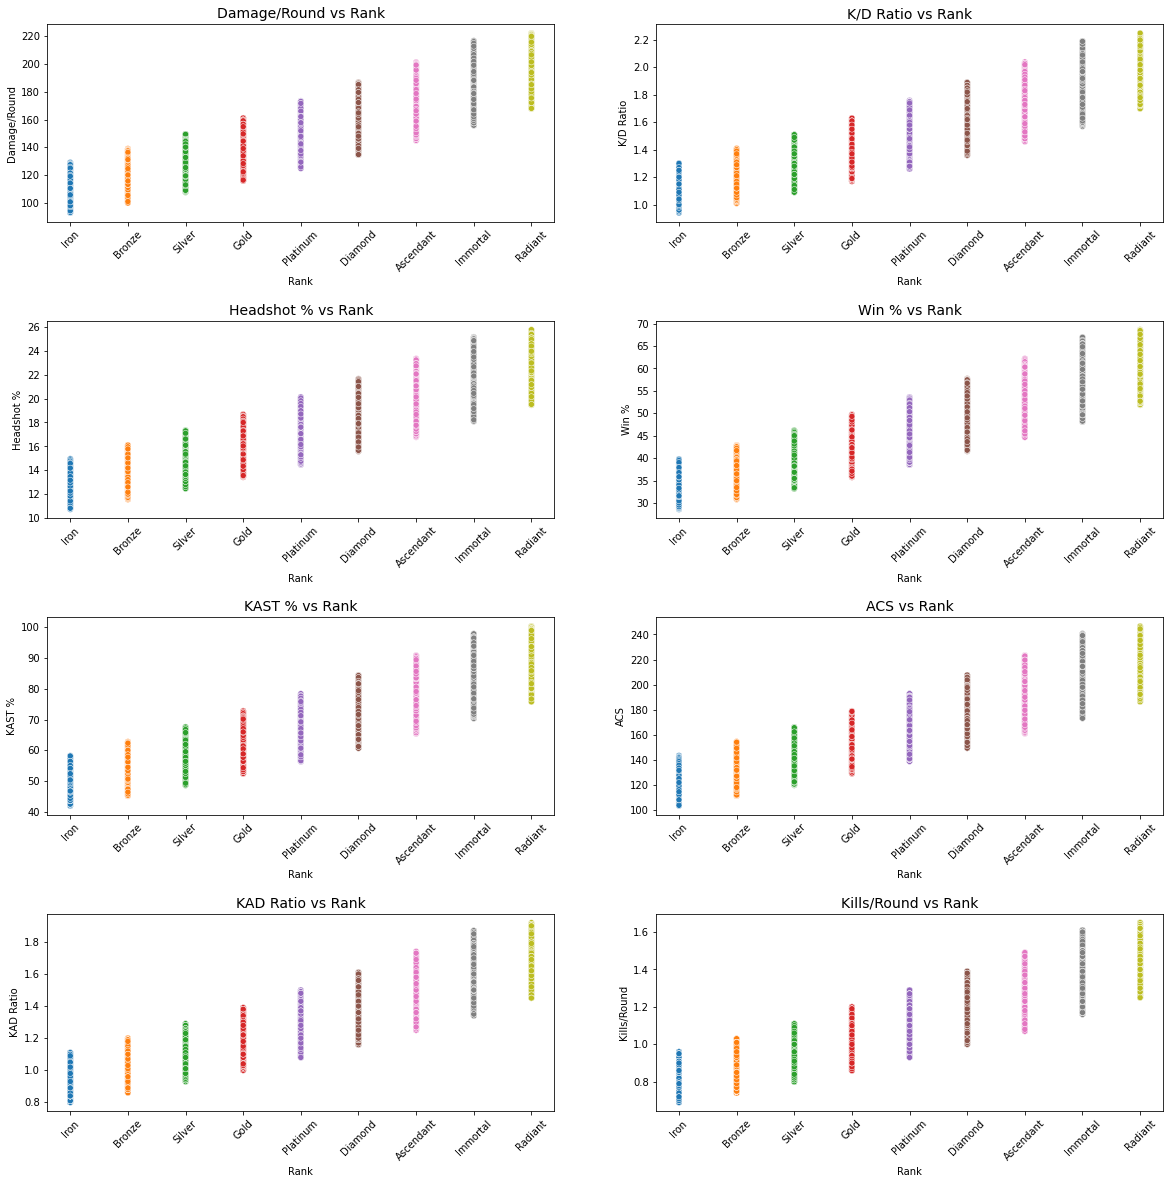

In [15]:
# Create scatter plots for each column against Rank
stats_columns = [col for col in df.columns if col != 'NewRank' and col != 'DDΔ/Round']

# Set up the plot grid
n_cols = 2  # Number of columns in the grid
n_rows = -(-len(stats_columns) // n_cols)  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

# Flatten axes for easy indexing
axes = axes.flatten()

# Plot each stat
for i, stat in enumerate(stats_columns):
    sns.scatterplot(data=df, x='NewRank', y=stat, ax=axes[i], hue='NewRank', palette='tab10')
    axes[i].set_title(f"{stat} vs Rank", fontsize=14)
    axes[i].set_xlabel("Rank")
    axes[i].set_ylabel(stat)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend().remove()

# Adjust the vertical space between subplots
plt.subplots_adjust(hspace=0.5)  # Increase the value to add more space    
    
# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.legend().remove()
plt.show()

Let us now analyze their means to see if stats truly do determine rank.

In [16]:
mean_stats = df.groupby("NewRank").mean()
mean_stats.sort_values(by='ACS')

,Damage/Round,K/D Ratio,Headshot %,Win %,KAST %,DDΔ/Round,ACS,KAD Ratio,Kills/Round
NewRank,,,,,,,,,
Iron,110.552771,1.117326,12.809577,34.126277,49.935107,9.658400,122.676573,0.953539,0.820289
Bronze,119.044621,1.203821,13.798049,36.746034,53.749921,10.339333,132.191071,1.026411,0.883627
Silver,128.193357,1.296123,14.871603,39.601172,57.886092,10.994067,142.262337,1.106673,0.951173
Gold,138.020457,1.396545,15.999650,42.654847,62.389503,12.003267,153.313101,1.190985,1.024070
Platinum,148.547904,1.502536,17.237593,45.887218,67.168813,12.999067,165.176293,1.281669,1.103765
Diamond,160.015491,1.619050,18.556917,49.411281,72.311821,13.998667,177.621209,1.380886,1.188133
Ascendant,172.399684,1.743215,20.004979,53.307187,77.920535,15.000400,191.286131,1.487355,1.279677
Immortal,185.870033,1.877089,21.523769,57.381544,83.850313,16.005733,206.003345,1.601171,1.378319
Radiant,195.159994,1.970138,22.584080,60.242806,88.142934,16.988800,216.625348,1.681138,1.446192


Guess they do.

Let's try some custom usernames!

In [17]:
from selenium import webdriver
from bs4 import BeautifulSoup

In [18]:
from utils import find_rank, find_highlighted_stats

def predict_rank(username):
    with webdriver.Chrome() as driver:
        print("Scraping", username)
        # Scrape from '/overview'
        driver.get(f"https://tracker.gg/valorant/profile/riot/{username.replace('#', '%23')}/overview")
        page_source = driver.page_source

    # Parse HTML
    soup = BeautifulSoup(page_source, 'html.parser')
    rank = find_rank(soup)
    stats = find_highlighted_stats(soup)
    stats = [float(stat.replace('%', '').replace(',', '')) for stat in stats.values()]
    return stats + [rank]

In [19]:
stats = predict_rank('EG NaturE#RAT')

Scraping EG NaturE#RAT


In [20]:
import numpy as np

# Your single row of data
single_row = stats[:-4]

# Convert the data to a NumPy array and reshape it for prediction
single_row = np.array(single_row, dtype=float).reshape(1, -1)

# Predict the output
y_single_pred = clf.predict(single_row)

y_single_pred_decoded = label_encoder.inverse_transform(y_single_pred)
print("Predicted Rank:", y_single_pred_decoded[0])

Predicted Rank: Radiant


C:\Users\91959\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
